In [ ]:
pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 1.2 MB/s eta 0:00:00


In [ ]:
import os
import datetime
import chess
import chess.engine
import random
import numpy as np
import math
from tqdm import tqdm
import io
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, SVG
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!apt-get install -y stockfish

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  polyglot xboard | scid
The following NEW packages will be installed:
  stockfish
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 24.8 MB of archives.
After this operation, 47.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 stockfish amd64 14.1-1 [24.8 MB]
Fetched 24.8 MB in 3s (8,535 kB/s)
Selecting previously unselected package stockfish.
(Reading database ... 121753 files and directories currently installed.)
Preparing to unpack .../stockfish_14.1-1_amd64.deb ...
Unpacking stockfish (14.1-1) ...
Setting up stockfish (14.1-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
# help functions

def stockfish(board, depth):
  with chess.engine.SimpleEngine.popen_uci("/usr/games/stockfish") as sf:
    result = sf.analyse(board, chess.engine.Limit(depth=depth))
    score = result['score'].white().score()
  return score

def board_encoder(board):
  encoded_board = np.zeros([8,8,13]).astype(np.int8)
  fen = board.fen()
  fen_field = fen.split(' ')
  PiecePlacement = fen_field[0].split('/')
  piece_dict = {"R":0, "N":1, "B":2, "Q":3, "K":4, "P":5,
                "r":6, "n":7, "b":8, "q":9, "k":10, "p":11
                }
  for rank in range(8):
    pieces = ''
    for c in PiecePlacement[rank]:
      if c.isnumeric():
        pieces += '-'*int(c)
      else:
        pieces += c
    for file in range(8):
      if pieces[file] != '-':
        encoded_board[rank, file, piece_dict[pieces[file]]] = 1
  # # plane 12 encodes all the legal moves of white
  # aux = board.turn
  # board.turn = chess.WHITE
  # for move in board.legal_moves:
  #   encoded_board[7-np.unravel_index(move.to_square, (8,8))[0], np.unravel_index(move.to_square, (8,8))[1], 12] = 1
  # # plane 13 encodes all the legal moves of black
  # board.turn = chess.BLACK
  # for move in board.legal_moves:
  #   encoded_board[7-np.unravel_index(move.to_square, (8,8))[0], np.unravel_index(move.to_square, (8,8))[1], 13] = 1
  # board.turn = aux
  # plane 14 encodes the current player to move: white is 1, black is 0
  if fen_field[1] == 'w':
    encoded_board[:,:,12] = 1
  else:
    encoded_board[:,:,12] = 0
  return encoded_board

In [ ]:
# Set the random seed
np.random.seed(42)

In [ ]:
# load training data
for i in range(1,10):
  data = np.load("/content/drive/MyDrive/dataset_lichess{}.Mar18.npz".format(i))
  if i == 1:
    X = data['X']
    y = data['y']
  else:
    X = np.concatenate((X, data['X']))
    y = np.concatenate((y, data['y']))

idx_to_pick = np.concatenate((np.arange(0, 12), [14]))
inputdata = {'X': X[:,:,:,idx_to_pick], 'y': y}

Text(0.5, 1.0, 'evaluation score distribution')

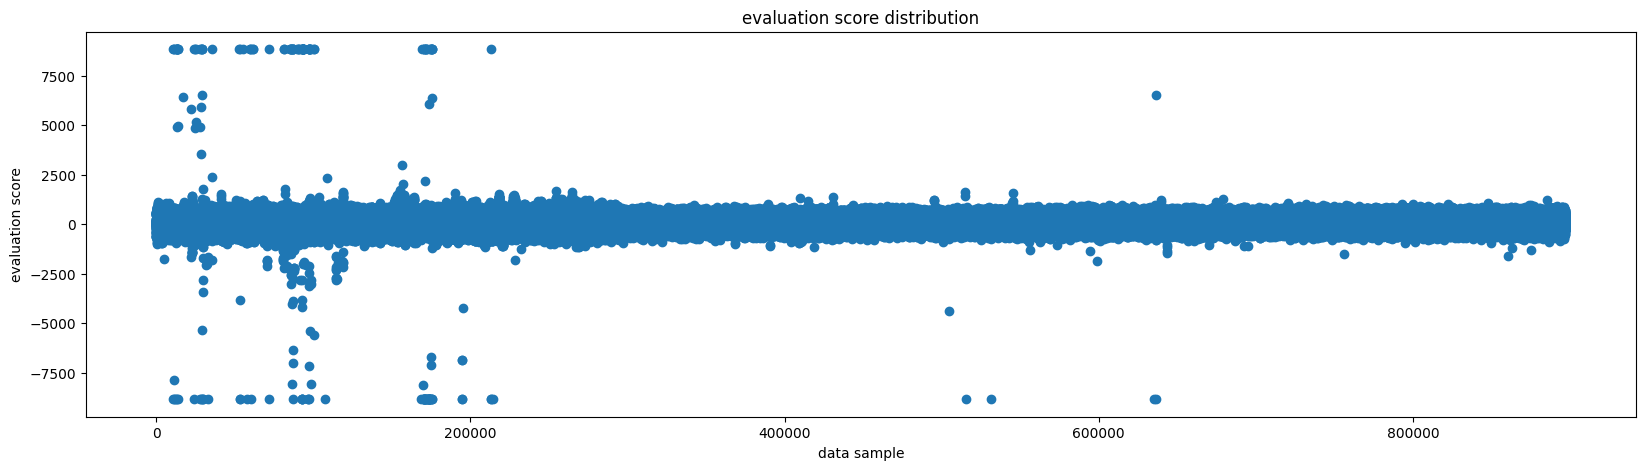

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(20, 5))

axs.scatter([e for e in range(len(inputdata['y']))], inputdata['y'])
axs.set_xlabel("data sample")
axs.set_ylabel("evaluation score")
axs.set_title("evaluation score distribution")

In [ ]:
mean = np.mean(inputdata['y'])
std_dev = np.std(inputdata['y'])
thres_high = mean + 2 * std_dev
thres_low = mean - 2 * std_dev

print(thres_high)
print(thres_low)

# Find the indices of samples that satisfy the filtering condition
filtered_indices = np.where((inputdata['y'] <= thres_high) & (inputdata['y'] >= thres_low))[0]

# Get the filtered data based on the filtered indices
filtered_data = inputdata['y'][filtered_indices]

507.62531026745927
-399.41332253696027


In [ ]:
filtered_data.shape

(848835,)

Text(0.5, 1.0, 'evaluation score distribution after outlier removal')

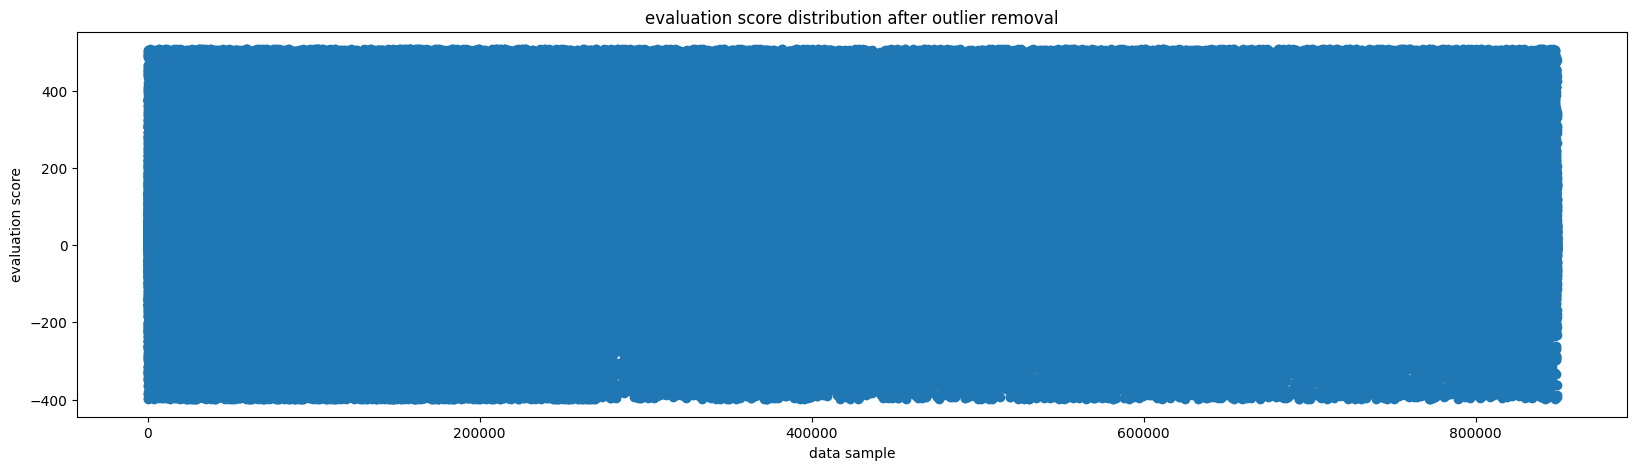

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(20, 5))

axs.scatter([e for e in range(len(filtered_data))], filtered_data)
axs.set_xlabel("data sample")
axs.set_ylabel("evaluation score")
axs.set_title("evaluation score distribution after outlier removal")

In [ ]:
X_filtered = X[filtered_indices]
X_filtered = X_filtered[:,:,:,idx_to_pick]
y_filtered = y[filtered_indices]
inputdata = {'X': X_filtered, 'y': y_filtered}

In [ ]:
inputdata['X'].shape

(848835, 8, 8, 13)

In [ ]:
# load validation data

valdata = np.load("/content/drive/MyDrive/dataset_lichess10.Mar18.npz")

mean = np.mean(valdata['y'])
std_dev = np.std(valdata['y'])
thres_high = mean + 2 * std_dev
thres_low = mean - 2 * std_dev

print(thres_high)
print(thres_low)

# Find the indices of samples that satisfy the filtering condition
filtered_indices = np.where((valdata['y'] <= thres_high) & (valdata['y'] >= thres_low))[0]

# Get the filtered data based on the filtered indices
filtered_data = inputdata['y'][filtered_indices]

X_filtered = valdata['X'][filtered_indices]
X_filtered = X_filtered[:,:,:,idx_to_pick]
y_filtered = valdata['y'][filtered_indices]
validation_set = {'X': X_filtered, 'y': y_filtered}

396.3441964522211
-269.15814295056794


Text(0.5, 1.0, 'validation set evaluation score distribution after outlier removal')

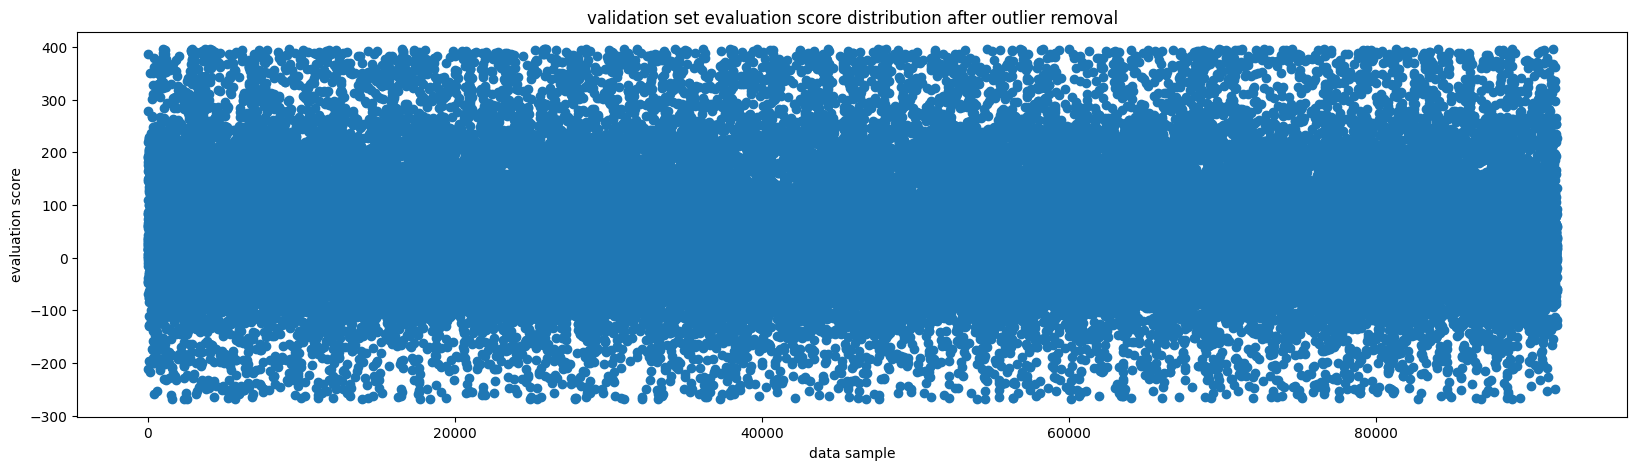

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(20, 5))

axs.scatter([e for e in range(len(validation_set['y']))], validation_set['y'])
axs.set_xlabel("data sample")
axs.set_ylabel("evaluation score")
axs.set_title("validation set evaluation score distribution after outlier removal")

In [ ]:
# model components

class ConvBlock(nn.Module):
    def __init__(self, channel_in=13, channel_out=256, kernel_size=3, stride=1):
        super(ConvBlock, self).__init__()
        self.channel_in = channel_in
        self.conv1 = nn.Conv2d(channel_in, channel_out, kernel_size=kernel_size,
                               stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(channel_out)

    def forward(self, s):
        if s.dtype != torch.float32:
            s = s.float()
        s = s.view(-1, self.channel_in, 8, 8)  # batch_size x channels x board_x x board_y
        s = self.conv1(s)
        s = self.bn1(s)
        s = F.relu(s)
        return s

class ResBlock(nn.Module):
    def __init__(self, channel_in=256, channel_out=256, kernel_size=3, stride=1,
                 downsample=None):
        super(ResBlock, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv1 = nn.Conv2d(channel_in, channel_out, kernel_size=kernel_size,
                               stride=stride,
                     padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(channel_out)
        self.conv2 = nn.Conv2d(channel_out, channel_out, kernel_size=kernel_size,
                               stride=stride,
                     padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(channel_out)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = F.relu(out)
        return out

class OutBlock(nn.Module):
    def __init__(self):
        super(OutBlock, self).__init__()
        self.conv = nn.Conv2d(256, 1, kernel_size=1, stride=1)
        self.bn = nn.BatchNorm2d(1)
        self.fc1 = nn.Linear(8*8, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self,s):
        v = self.conv(s)
        v = self.bn(v)
        v = F.relu(v)
        v = v.view(-1, 8*8)  # batch_size x channels x board_x x board_y
        v = self.fc1(v)
        v = F.relu(v)
        v = self.fc2(v)
        v = torch.tanh(v)

        return v

In [ ]:
# 7 layers of residual blocks

class ResNet7(nn.Module):
    def __init__(self):
        super(ResNet7, self).__init__()
        self.conv = ConvBlock()
        self.resblocks = nn.ModuleList([ResBlock() for _ in range(7)])
        self.outblock = OutBlock()

    def forward(self,s):
        s = self.conv(s)
        for resblock in self.resblocks:
            s = resblock(s)
        s = self.outblock(s)
        return s

In [ ]:
# initialize a normalizer for the evaluation score

normalizer = MinMaxScaler(feature_range=(-1, 1)).fit(inputdata['y'].reshape(-1,1))

In [ ]:
class data_prep():
    def __init__(self, dataset): # dataset = np.array of (s, v)
        # self.X = dataset[:,0]
        # self.y = dataset[:,1]
        self.X = dataset['X']
        self.y = normalizer.transform(dataset['y'].reshape(-1,1))
        self.y = self.y.reshape(-1,)

    def __len__(self):
        return len(self.X)

    def __getitem__(self,idx):
        return self.X[idx].transpose(2,0,1), self.y[idx]

In [ ]:
# validation function

def validate(net, val_loader, criterion):
    net.eval()  # Switch model to evaluation mode
    total_loss = 0.0
    num_batches = 0
    for i, data in enumerate(val_loader):
        state, value = data
        if cuda:
            state, value = state.cuda().float(), value.cuda().float()
        value = value.float()  # Convert to torch.float32
        with torch.no_grad():  # Disable gradient calculation
            value_pred = net(state)  # value_pred = torch.Size([batch, 1])
            loss = criterion(value_pred[:, 0], value)
        total_loss += loss.item()
        num_batches += 1
    average_loss = total_loss / num_batches
    return average_loss

In [ ]:
def train(net, train_data, val_data, batch_size=100, epoch_start=0, epoch_stop=20, checkpoint_interval=10, early_stop_patience=5):
    cuda = torch.cuda.is_available()
    net.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    # scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                              #  milestones=[100,200,300,400],
                                              #  gamma=0.2)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.2)
    train_set = data_prep(train_data)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                              num_workers=2, pin_memory=False)
    val_set = data_prep(val_data)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False,
                            num_workers=2, pin_memory=False)
    losses_per_epoch = []
    val_losses_per_epoch = []
    lr = []
    patience_count = 0
    for epoch in range(epoch_start, epoch_stop):
        total_loss = 0.0
        losses_per_batch = []
        for i,data in enumerate(train_loader):
            state, value = data
            if cuda:
                state, value = state.cuda().float(), value.cuda().float()
            value = value.float()  # Convert to torch.float32
            optimizer.zero_grad()
            value_pred = net(state) # value_pred = torch.Size([batch, 1])
            loss = criterion(value_pred[:,0], value)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches of size = batch_size
                print('Process ID: %d [Epoch: %d, %5d/ %d points] total loss per batch: %.5f' %
                      (os.getpid(), epoch + 1, (i + 1)*batch_size, len(train_set), total_loss/10))
                print("Value:",value[0].item(),value_pred[0,0].item())
                losses_per_batch.append(total_loss/10)
                total_loss = 0.0
        losses_per_epoch.append(sum(losses_per_batch)/len(losses_per_batch))
        # Validation
        val_loss = validate(net, val_loader, criterion)
        print(f'Validation MSE Loss: {val_loss:.5f}')
        val_losses_per_epoch.append(val_loss)
        scheduler.step(val_loss)
        # Print learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current learning rate: {current_lr}")
        lr.append(current_lr)
        # Early stopping: validation loss has to reduce at least 5% per epoch
        if len(val_losses_per_epoch) >= 6:
          loss_avg = np.average(val_losses_per_epoch[-6:-1])
          if val_loss <= 0.95 * loss_avg:
            patience_count = 0  # Reset patience count
          else:
            patience_count += 1
        if patience_count >= early_stop_patience:
          np.savez("/content/drive/MyDrive/ResNet7_Mar26/ResNet7_Mar27_losses_per_epoch_epoch{}.npz".format(epoch+1),
                train_loss=losses_per_epoch,
                val_loss=val_losses_per_epoch,
                lr=lr
                )
          torch.save({'state_dict': net.state_dict()},
                  "/content/drive/MyDrive/ResNet7_Mar26/ResNet7_Mar27_training_checkpoint_epoch{}.ckpt".format(epoch+1))
          print(f'Early stopping! No improvement in validation loss for {early_stop_patience} epochs.')
          break
        # Save checkpoints
        if epoch % checkpoint_interval == 9:
          np.savez("/content/drive/MyDrive/ResNet7_Mar26/ResNet7_Mar27_losses_per_epoch_epoch{}.npz".format(epoch+1),
                   train_loss=losses_per_epoch,
                   val_loss=val_losses_per_epoch,
                   lr=lr
                   )
          losses_per_epoch = []
          val_losses_per_epoch = []
          lr = []
          torch.save({'state_dict': net.state_dict()},
                     "/content/drive/MyDrive/ResNet7_Mar26/ResNet7_Mar27_training_checkpoint_epoch{}.ckpt".format(epoch+1))

In [ ]:
# train net
net = ResNet7()
cuda = torch.cuda.is_available()
if cuda:
  net.cuda()
# current_net_filename = r"C:\Users\Richard.Huang\OneDrive - TGS\Desktop\Jupyter\AlphaZero\model_data\ResNet7_training1.pth.tar"
# checkpoint = torch.load(current_net_filename)
# net.load_state_dict(checkpoint['state_dict'])
train(net,inputdata, validation_set, epoch_stop=50)
# save results
torch.save({'state_dict': net.state_dict()}, "/content/drive/MyDrive/ResNet7_Mar26/ResNet7_March27_trained.pth.tar")
from google.colab import runtime
runtime.unassign()

Streaming output truncated to the last 5000 lines.
Value: -0.12141280621290207 -0.12499934434890747
Process ID: 678 [Epoch: 18, 49000/ 848835 points] total loss per batch: 0.00891
Value: 0.06401766091585159 -0.035968560725450516
Process ID: 678 [Epoch: 18, 50000/ 848835 points] total loss per batch: 0.00955
Value: -0.17880794405937195 -0.06122250482439995
Process ID: 678 [Epoch: 18, 51000/ 848835 points] total loss per batch: 0.01009
Value: -0.7350993156433105 -0.6885474920272827
Process ID: 678 [Epoch: 18, 52000/ 848835 points] total loss per batch: 0.00817
Value: -0.13024282455444336 -0.12402243912220001
Process ID: 678 [Epoch: 18, 53000/ 848835 points] total loss per batch: 0.00835
Value: -0.7373068332672119 -0.5912787914276123
Process ID: 678 [Epoch: 18, 54000/ 848835 points] total loss per batch: 0.01101
Value: 0.29801324009895325 0.2606138586997986
Process ID: 678 [Epoch: 18, 55000/ 848835 points] total loss per batch: 0.00989
Value: 0.366445928812027 0.39835044741630554
Process 

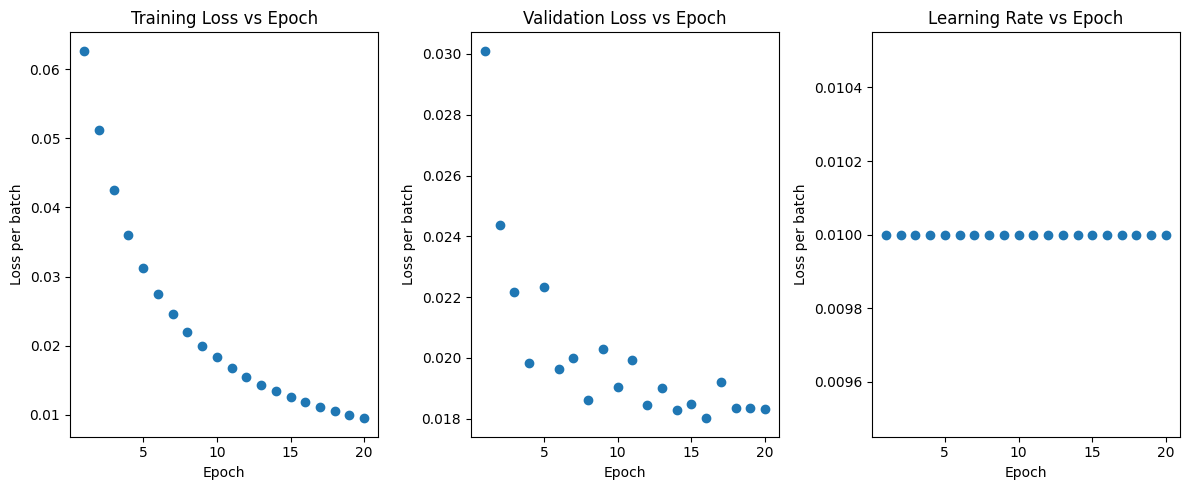

In [ ]:
losses_per_epoch_training = []
losses_per_epoch_validation = []
lr = []
for i in range(50):
  try:
    losses = np.load("/content/drive/MyDrive/ResNet7_Mar26/ResNet7_Mar27_losses_per_epoch_epoch{}.npz".format(i))
    losses_per_epoch_training.extend(losses['train_loss'])
    losses_per_epoch_validation.extend(losses['val_loss'])
    lr.extend(losses['lr'])
  except:
    continue

# losses = np.load("/content/drive/MyDrive/ResNet7_Mar22/losses_per_epoch_ResNet7_epoch40.npz")
# losses_per_epoch_training.extend(losses['train_loss'])
# losses_per_epoch_validation.extend(losses['val_loss'])

# plot loss per epoch
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

axs[0].scatter([e for e in range(1, len(losses_per_epoch_training)+1)], losses_per_epoch_training)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss per batch")
axs[0].set_title("Training Loss vs Epoch")

axs[1].scatter([e for e in range(1, len(losses_per_epoch_training)+1)], losses_per_epoch_validation)
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss per batch")
axs[1].set_title("Validation Loss vs Epoch")

axs[2].scatter([e for e in range(1, len(losses_per_epoch_training)+1)], lr)
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Loss per batch")
axs[2].set_title("Learning Rate vs Epoch")

plt.tight_layout()
plt.show()